# IMPORT LIBRARIES

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od

import torch
from torchvision import transforms, datasets
from torch.nn import functional as F
from torch.utils import data
from torch import nn
from PIL import Image, ImageFilter
from IPython.display import display
from skimage.filters import sobel
from sklearn import metrics

import math
import os
import cv2

import matplotlib.font_manager as fm

import pandas as pd
import skimage.io

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import tensorflow as tf

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU, MaxPooling2D, Activation, Add, Input, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

# LOAD DATA

In [6]:
od.download("https://www.kaggle.com/datasets/gpreda/chinese-mnist")
# {"username":"hungcai13","key":"c849f4c74776081678f60df602526b31"}

Skipping, found downloaded files in ".\chinese-mnist" (use force=True to force download)


# DISPLAY DATA DISTRIBUTION

In [7]:
# read csv file for testing values
data_csv = pd.read_csv('./chinese-mnist/chinese_mnist.csv')

#display data size group by value and character
data_csv.groupby(["value", "character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

# CHECK FOR MISSING DATA

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
total = data_csv.isnull().sum().sort_values(ascending=False)
percentage = (data_csv.isnull().sum()/data_csv.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=["total missing", "percentage"])
missing_data

,total missing,percentage
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


# CHECK FOR MISSING IMAGE

In [10]:
folder = "./chinese-mnist/data/data/"
print("Number of images files: {}".format(len(os.listdir(folder))))

Number of images files: 15000


# Append image path and sizes

In [11]:
def image_files(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name
data_csv["file"] = data_csv.apply(image_files, axis=1)

def image_sizes(file_name):
    image = skimage.io.imread(folder + file_name)
    return list(image.shape)

image_size = np.stack(data_csv['file'].apply(image_sizes))
image_size_csv = pd.DataFrame(image_size,columns=['w','h'])
data_csv = pd.concat([data_csv,image_size_csv],axis=1, sort=False)

data_csv.head()

,suite_id,sample_id,code,value,character,file,w,h
0,1,1,10,9,九,input_1_1_10.jpg,64,64
1,1,10,10,9,九,input_1_10_10.jpg,64,64
2,1,2,10,9,九,input_1_2_10.jpg,64,64
3,1,3,10,9,九,input_1_3_10.jpg,64,64
4,1,4,10,9,九,input_1_4_10.jpg,64,64


# SPLIT THE DATASET

In [12]:
# print(train_test_split(data_csv, test_size=0.2, random_state=0, stratify=data_csv["code"].values))
train_ds, test_validation_ds = train_test_split(data_csv, test_size=0.2, random_state=0, stratify=data_csv["code"].values)
print("Train dataset size: {}".format(train_ds.shape[0]))
# print(train_test_split(test_validation_ds, test_size=0.2, random_state=0, stratify=test_validation_ds["code"].values))
test_ds, validation_ds = train_test_split(test_validation_ds, test_size=0.2, random_state=0, stratify=test_validation_ds["code"].values)
print("Test dataset size: {}".format(test_ds.shape[0]))
print("Validation dataset size: {}".format(validation_ds.shape[0]))

Train dataset size: 12000
Test dataset size: 2400
Validation dataset size: 600


# RESHAPE AND NORMALIZE IMAGE

In [13]:
def read_image(file_name):
    image = skimage.io.imread(folder + file_name)
    image = skimage.transform.resize(image, (64, 64, 3), mode='reflect')
    return image

def categories_encoder(dataset, var='character'):
    x = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return x, y

x_train, y_train = categories_encoder(train_ds)
x_val, y_val = categories_encoder(validation_ds)
x_test, y_test = categories_encoder(test_ds)

# Display images

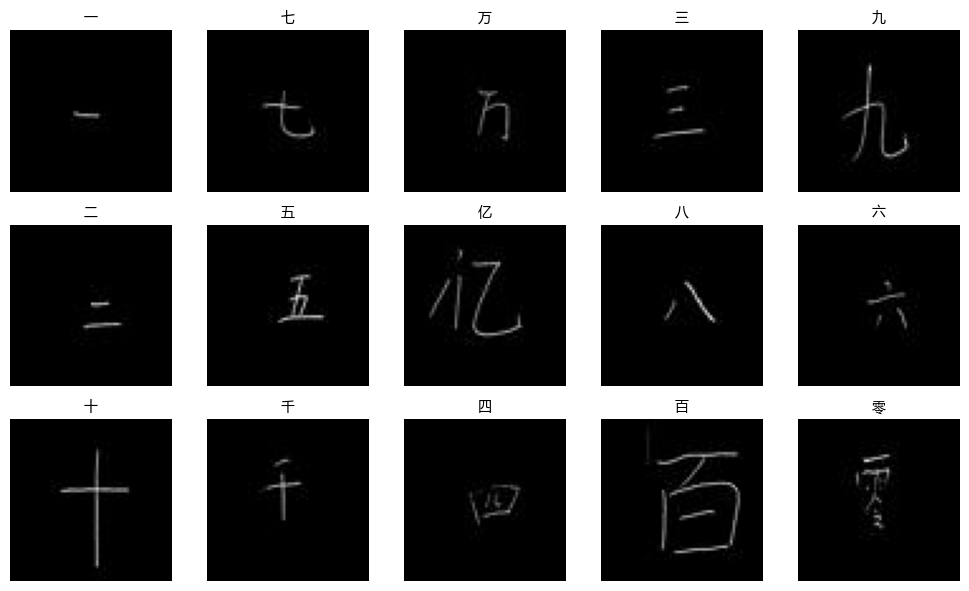

In [14]:
# Get the index of the first instance of each label in y_train
category_indices = [np.argmax(y_train[label].values) for label in y_train.columns]
prop = fm.FontProperties(fname='C:/Windows/Fonts/msyh.ttc')

# Display an image for each label
fig = plt.figure(figsize=(10, 6))
for i, idx in enumerate(category_indices):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(y_train.columns[i], fontproperties=prop)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# CUSTOM MODEL

In [95]:
## This model is based on the model used by researchers in the article "Online and Offline Hndwritten Chinese Character Recognition: A Comprehensive Study and New Benchmark"
## Don't use this model since it is too complex for this dataset and therefore leads to overfitting

# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'))
# model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(100, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(100, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(150, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(150, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(200, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(200, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(250, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(250, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(300, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(300, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(350, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(350, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(1, 1)))

# model.add(Conv2D(400, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(Conv2D(400, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(1, 1)))

# # Flatten the output from the convolutional layers
# model.add(Flatten())

# # Fully connected layers
# model.add(Dense(900, activation='relu'))
# model.add(Dense(200, activation='relu'))

# # Output layer
# model.add(Dense(15, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()



custom_model = Sequential()

custom_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(64, (3,3), activation='relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(128, (3,3), activation='relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Flatten())

custom_model.add(Dense(64, activation='relu'))
custom_model.add(Dense(y_train.columns.size, activation='softmax'))
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

custom_model.summary()



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_139 (Conv2D)         (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_140 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_141 (Conv2D)         (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 128)      

In [96]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Define learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)



train_model = custom_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/50
375/375 [==============================] - 10s 26ms/step - loss: 1.8503 - accuracy: 0.3340 - val_loss: 0.7870 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 2/50
375/375 [==============================] - 10s 26ms/step - loss: 0.9455 - accuracy: 0.6522 - val_loss: 0.5468 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 3/50
375/375 [==============================] - 10s 26ms/step - loss: 0.6574 - accuracy: 0.7718 - val_loss: 0.2968 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 4/50
375/375 [==============================] - 10s 28ms/step - loss: 0.5477 - accuracy: 0.8086 - val_loss: 0.2711 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 5/50
375/375 [==============================] - 14s 37ms/step - loss: 0.4572 - accuracy: 0.8393 - val_loss: 0.3191 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 6/50
375/375 [==============================] - 9s 25ms/step - loss: 0.3929 - accuracy: 0.8660 - val_loss: 0.1701 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 7/50
375/375 [==============================] - 9s 25

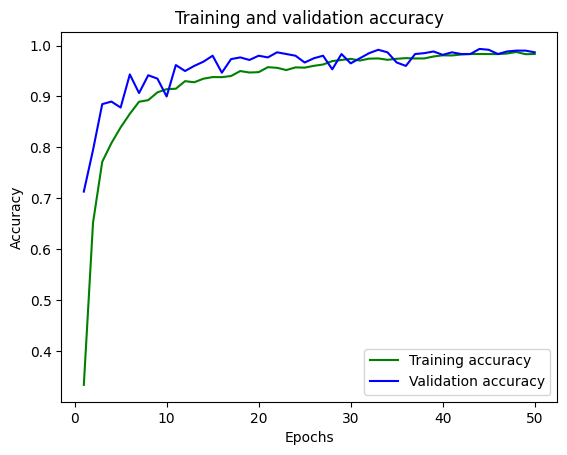

In [97]:
# Access accuracy values for training and validation sets
train_acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

# Plot accuracy vs epochs
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [98]:
custom_model.evaluate(x_test, y_test)

75/75 [==============================] - 0s 4ms/step - loss: 0.0351 - accuracy: 0.9879


[0.03508700057864189, 0.9879166483879089]

In [99]:
print(metrics.classification_report(np.argmax(y_test.values,axis=1), np.argmax(custom_model.predict(x_test),axis=1), target_names=y_test.columns))

75/75 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           一       1.00      0.97      0.99       160
           七       1.00      0.96      0.98       160
           万       0.99      0.97      0.98       160
           三       0.98      0.99      0.99       160
           九       0.97      0.97      0.97       160
           二       0.97      0.99      0.98       160
           五       0.99      1.00      0.99       160
           亿       0.96      0.99      0.98       160
           八       1.00      1.00      1.00       160
           六       0.99      0.99      0.99       160
           十       1.00      0.98      0.99       160
           千       0.98      0.99      0.99       160
           四       0.99      1.00      0.99       160
           百       0.99      0.99      0.99       160
           零       1.00      1.00      1.00       160

    accuracy                           0.99      2400
   macro avg       0.99    

# VGG LIKE MODEL

In [100]:
vgg_model=Sequential()
vgg_model.add(Conv2D(32, kernel_size=3, input_shape=(64, 64, 3), activation='relu', padding='same'))
vgg_model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(MaxPool2D(2))
vgg_model.add(Dropout(0.25))

vgg_model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(MaxPool2D(2))
vgg_model.add(Dropout(0.25))

vgg_model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(MaxPool2D(2))
vgg_model.add(Dropout(0.25))

vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(y_train.columns.size, activation='softmax'))
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 conv2d_143 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_144 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 conv2d_145 (Conv2D)         (None, 32, 32, 64)        36928     
                                                     

In [101]:
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Define learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)



train_model = vgg_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/50
375/375 [==============================] - 10s 26ms/step - loss: 2.1224 - accuracy: 0.2311 - val_loss: 1.1590 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 2/50
375/375 [==============================] - 9s 25ms/step - loss: 1.1406 - accuracy: 0.5715 - val_loss: 0.3798 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 3/50
375/375 [==============================] - 10s 26ms/step - loss: 0.6668 - accuracy: 0.7655 - val_loss: 0.1586 - val_accuracy: 0.9483 - lr: 0.0010
Epoch 4/50
375/375 [==============================] - 10s 27ms/step - loss: 0.4502 - accuracy: 0.8453 - val_loss: 0.1184 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 5/50
375/375 [==============================] - 10s 26ms/step - loss: 0.3662 - accuracy: 0.8765 - val_loss: 0.0551 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/50
375/375 [==============================] - 9s 25ms/step - loss: 0.3168 - accuracy: 0.8985 - val_loss: 0.0575 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 7/50
375/375 [==============================] - 9s 25m

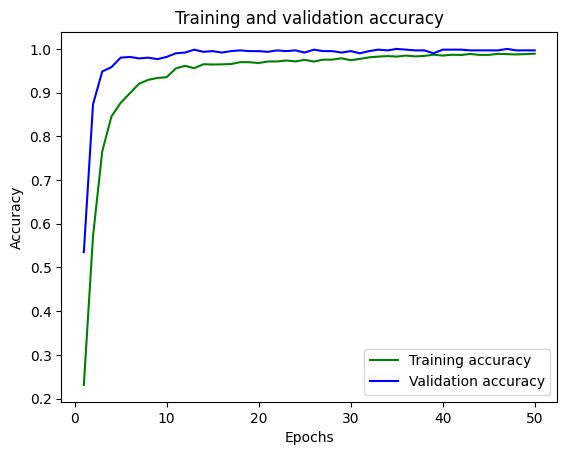

In [102]:
# Access accuracy values for training and validation sets
train_acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

# Plot accuracy vs epochs
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [103]:
vgg_model.evaluate(x_test, y_test)

75/75 [==============================] - 0s 5ms/step - loss: 0.0083 - accuracy: 0.9967


[0.00832329597324133, 0.996666669845581]

In [104]:
print(metrics.classification_report(np.argmax(y_test.values,axis=1), np.argmax(vgg_model.predict(x_test),axis=1), target_names=y_test.columns))

75/75 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           一       1.00      0.99      1.00       160
           七       1.00      0.99      1.00       160
           万       0.99      1.00      1.00       160
           三       1.00      1.00      1.00       160
           九       0.99      0.99      0.99       160
           二       0.99      1.00      1.00       160
           五       1.00      0.99      1.00       160
           亿       0.99      1.00      1.00       160
           八       1.00      1.00      1.00       160
           六       1.00      0.99      0.99       160
           十       1.00      0.99      1.00       160
           千       0.99      1.00      0.99       160
           四       0.99      1.00      1.00       160
           百       1.00      0.99      1.00       160
           零       1.00      1.00      1.00       160

    accuracy                           1.00      2400
   macro avg       1.00    

# RES-NET50 LIKE MODEL

In [105]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def convolution_block(x, filters, kernel_size, strides=(2, 2), padding='same'):
    shortcut = x
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), padding='valid')(x)
    x = BatchNormalization(axis=3)(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides, padding='valid')(shortcut)
    shortcut = BatchNormalization(axis=3)(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def identity_block(x, filters, kernel_size):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), padding='valid')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), padding='valid')(x)
    x = BatchNormalization(axis=3)(x)

    x = Add()([x, x])
    x = Activation('relu')(x)
    return x


def resnet50(input_shape=(64,64,3), num_classes=15):
    x_input = Input(input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = convolution_block(x, filters=[64, 64, 256], kernel_size=(3, 3), strides=(1, 1), padding='same')
    x = identity_block(x, filters=[64, 64, 256], kernel_size=(3, 3))
    x = identity_block(x, filters=[64, 64, 256], kernel_size=(3, 3))

    x = convolution_block(x, filters=[128, 128, 512], kernel_size=(3, 3), strides=(2, 2), padding='same')
    x = identity_block(x, filters=[128, 128, 512], kernel_size=(3, 3))
    x = identity_block(x, filters=[128, 128, 512], kernel_size=(3, 3))
    x = identity_block(x, filters=[128, 128, 512], kernel_size=(3, 3))

    x = convolution_block(x, filters=[256, 256, 1024], kernel_size=(3, 3), strides=(2, 2), padding='same')
    x = identity_block(x, filters=[256, 256, 1024], kernel_size=(3, 3))
    x = identity_block(x, filters=[256, 256, 1024], kernel_size=(3, 3))
    x = identity_block(x, filters=[256, 256, 1024], kernel_size=(3, 3))
    x = identity_block(x, filters=[256, 256, 1024], kernel_size=(3, 3))
    x = identity_block(x, filters=[256, 256, 1024], kernel_size=(3, 3))

    x = convolution_block(x, filters=[512, 512, 2048], kernel_size=(3, 3), strides=(2, 2), padding='same')
    x = identity_block(x, filters=[512, 512, 2048], kernel_size=(3, 3))
    x = identity_block(x, filters=[512, 512, 2048], kernel_size=(3, 3))

    x = AveragePooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x, name='Custom_ResNet50')

    return model


In [106]:
custom_resnet50_model = resnet50()
custom_resnet50_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_resnet50_model.summary()

Model: "Custom_ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_148 (Conv2D)            (None, 32, 32, 64)   9472        ['input_8[0][0]']                
                                                                                                  
 batch_normalization_106 (Batch  (None, 32, 32, 64)  256         ['conv2d_148[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_98 (Activation)     (None, 32, 32, 64)   0           ['batch_normalizati

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 batch_normalization_158 (Batch  (None, 2, 2, 2048)  8192        ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_47 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_158[0][0]',
                                                                  'batch_normalization_158[0][0]']
                                                                                                  
 activation_146 (Activation)    (None, 2, 2, 2048)   0           ['add_47[0][0]']                 
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 1, 1, 2048)  0           ['activation_146[0][0]']         
 oling2D)                                                                                         
          

In [107]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Define learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)



train_model = custom_resnet50_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/50
375/375 [==============================] - 23s 41ms/step - loss: 2.8321 - accuracy: 0.0859 - val_loss: 2.8782 - val_accuracy: 0.0767 - lr: 1.0000e-04
Epoch 2/50
375/375 [==============================] - 15s 40ms/step - loss: 2.7354 - accuracy: 0.0897 - val_loss: 3.1052 - val_accuracy: 0.1067 - lr: 1.0000e-04
Epoch 3/50
375/375 [==============================] - 15s 41ms/step - loss: 2.7177 - accuracy: 0.0953 - val_loss: 4.7500 - val_accuracy: 0.0867 - lr: 1.0000e-04
Epoch 4/50
375/375 [==============================] - 14s 36ms/step - loss: 2.6979 - accuracy: 0.0973 - val_loss: 4.2779 - val_accuracy: 0.0783 - lr: 1.0000e-04
Epoch 5/50
375/375 [==============================] - 14s 36ms/step - loss: 2.6604 - accuracy: 0.1078 - val_loss: 4.7031 - val_accuracy: 0.1017 - lr: 1.0000e-04
Epoch 6/50
375/375 [==============================] - 14s 37ms/step - loss: 2.6141 - accuracy: 0.1169 - val_loss: 4.5463 - val_accuracy: 0.1083 - lr: 1.0000e-04
Epoch 7/50
375/375 [==============

In [108]:
custom_resnet50_model.evaluate(x_test, y_test)

75/75 [==============================] - 1s 13ms/step - loss: 0.0508 - accuracy: 0.9829


[0.05076355114579201, 0.9829166531562805]

In [109]:
print(metrics.classification_report(np.argmax(y_test.values,axis=1), np.argmax(custom_resnet50_model.predict(x_test),axis=1), target_names=y_test.columns))

75/75 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           一       1.00      1.00      1.00       160
           七       0.98      0.97      0.97       160
           万       0.96      0.98      0.97       160
           三       0.96      0.99      0.98       160
           九       1.00      0.96      0.98       160
           二       0.99      1.00      0.99       160
           五       0.99      0.99      0.99       160
           亿       0.96      0.99      0.98       160
           八       0.99      1.00      1.00       160
           六       0.98      0.98      0.98       160
           十       0.99      0.98      0.98       160
           千       0.98      0.99      0.98       160
           四       0.99      0.97      0.98       160
           百       0.97      0.96      0.97       160
           零       0.99      0.99      0.99       160

    accuracy                           0.98      2400
   macro avg       0.98   

# RESNET-50 MODEL

In [15]:
r_model = Sequential()
r_model.add(tf.keras.applications.ResNet50(include_top=False, pooling='max', weights='imagenet', input_shape=(64,64,3)))
r_model.add(Dense(15, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
r_model.layers[0].trainable = False

In [16]:
annealer = LearningRateScheduler(lambda x: 1e-2 * 0.99 ** (x+10))
earlystopper = EarlyStopping(monitor='loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

In [17]:
r_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_model  = r_model.fit(x_train, y_train,
                  batch_size=32,
                  epochs=50,
                  verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/50
372/375 [============================>.] - ETA: 0s - loss: 2.1567 - accuracy: 0.3120
Epoch 1: val_accuracy improved from -inf to 0.39167, saving model to best_model.h5
375/375 [==============================] - 11s 14ms/step - loss: 2.1528 - accuracy: 0.3126 - val_loss: 1.7734 - val_accuracy: 0.3917 - lr: 0.0090
Epoch 2/50
371/375 [============================>.] - ETA: 0s - loss: 1.6761 - accuracy: 0.4684
Epoch 2: val_accuracy improved from 0.39167 to 0.50833, saving model to best_model.h5
375/375 [==============================] - 4s 11ms/step - loss: 1.6746 - accuracy: 0.4692 - val_loss: 1.5711 - val_accuracy: 0.5083 - lr: 0.0090
Epoch 3/50
374/375 [============================>.] - ETA: 0s - loss: 1.4879 - accuracy: 0.5256
Epoch 3: val_accuracy improved from 0.50833 to 0.58167, saving model to best_model.h5
375/375 [==============================] - 4s 11ms/step - loss: 1.4876 - accuracy: 0.5257 - val_loss: 1.3629 - val_accuracy: 0.5817 - lr: 0.0089
Epoch 4/50
371/375 [=

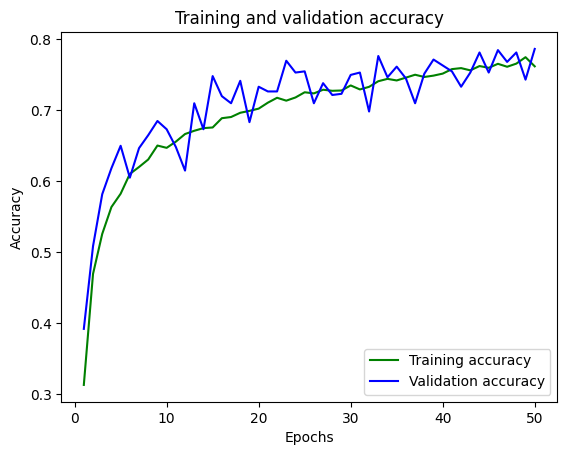

In [18]:
# Access accuracy values for training and validation sets
train_acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

# Plot accuracy vs epochs
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
r_model.evaluate(x_test, y_test)

75/75 [==============================] - 1s 17ms/step - loss: 0.7794 - accuracy: 0.7529


[0.7794010639190674, 0.752916693687439]

In [20]:
print(metrics.classification_report(np.argmax(y_test.values,axis=1), np.argmax(r_model.predict(x_test),axis=1), target_names=y_test.columns))

75/75 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           一       0.84      0.95      0.89       160
           七       0.71      0.82      0.76       160
           万       0.52      0.82      0.63       160
           三       0.69      0.64      0.66       160
           九       0.92      0.31      0.46       160
           二       0.73      0.69      0.71       160
           五       0.72      0.82      0.76       160
           亿       0.75      0.84      0.79       160
           八       0.90      0.98      0.94       160
           六       0.92      0.69      0.79       160
           十       0.86      0.67      0.75       160
           千       0.65      0.76      0.70       160
           四       0.65      0.81      0.72       160
           百       0.90      0.59      0.71       160
           零       0.93      0.91      0.92       160

    accuracy                           0.75      2400
   macro avg       0.78   

# VGG-16 MODEL

In [21]:
vgg_model = Sequential()
vgg_model.add(tf.keras.applications.VGG16(include_top=False, pooling='max', weights='imagenet', input_shape=(64,64,3)))
vgg_model.add(Dense(15, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
vgg_model.layers[0].trainable = False

In [22]:
annealer = LearningRateScheduler(lambda x: 1e-2 * 0.99 ** (x+10))
earlystopper = EarlyStopping(monitor='loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

In [23]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_model  = vgg_model.fit(x_train, y_train,
                  batch_size=32,
                  epochs=50,
                  verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/50
373/375 [============================>.] - ETA: 0s - loss: 0.9479 - accuracy: 0.7418
Epoch 1: val_accuracy improved from -inf to 0.88333, saving model to best_model.h5
375/375 [==============================] - 7s 16ms/step - loss: 0.9468 - accuracy: 0.7419 - val_loss: 0.4909 - val_accuracy: 0.8833 - lr: 0.0090
Epoch 2/50
373/375 [============================>.] - ETA: 0s - loss: 0.4319 - accuracy: 0.8805
Epoch 2: val_accuracy improved from 0.88333 to 0.91167, saving model to best_model.h5
375/375 [==============================] - 6s 15ms/step - loss: 0.4311 - accuracy: 0.8808 - val_loss: 0.3472 - val_accuracy: 0.9117 - lr: 0.0090
Epoch 3/50
373/375 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.9119
Epoch 3: val_accuracy improved from 0.91167 to 0.93167, saving model to best_model.h5
375/375 [==============================] - 6s 15ms/step - loss: 0.3212 - accuracy: 0.9121 - val_loss: 0.2769 - val_accuracy: 0.9317 - lr: 0.0089
Epoch 4/50
373/375 [==

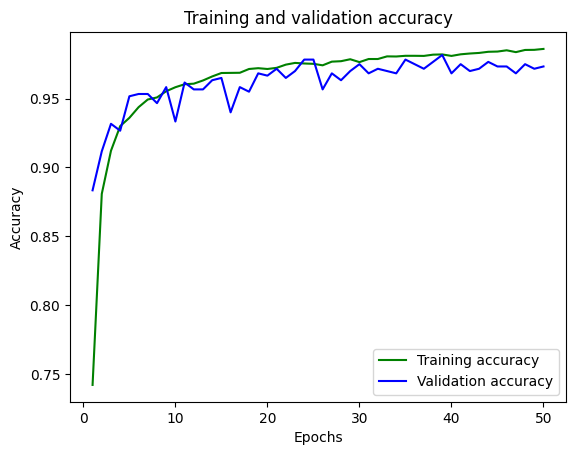

In [24]:
# Access accuracy values for training and validation sets
train_acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

# Plot accuracy vs epochs
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
vgg_model.evaluate(x_test, y_test)

75/75 [==============================] - 1s 14ms/step - loss: 0.0840 - accuracy: 0.9737


[0.08401045203208923, 0.9737499952316284]

In [26]:
print(metrics.classification_report(np.argmax(y_test.values,axis=1), np.argmax(vgg_model.predict(x_test),axis=1), target_names=y_test.columns))

75/75 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           一       1.00      1.00      1.00       160
           七       1.00      0.97      0.98       160
           万       0.96      0.97      0.96       160
           三       0.98      0.91      0.94       160
           九       0.89      0.99      0.94       160
           二       0.91      0.99      0.95       160
           五       0.99      0.99      0.99       160
           亿       0.99      0.93      0.96       160
           八       0.99      0.99      0.99       160
           六       0.99      0.95      0.97       160
           十       0.95      0.99      0.97       160
           千       0.99      0.96      0.97       160
           四       0.99      1.00      0.99       160
           百       0.99      0.96      0.98       160
           零       1.00      1.00      1.00       160

    accuracy                           0.97      2400
   macro avg       0.98   

15
